# Distributional Semantics

* What do words mean?
* The vector space model
* Latent semantic analysis
* Pointwise Mutual Information (PMI)
* Collocation extraction with PMI
* Word2Vec

## What do words mean?

* Dictionary definitions?
* Lexical categories?
* Relationship to other words? (Thesaurus)
* Context in which they appear?
* Referents in the "real world"?
* Effects in the mind of a listener?

#### The Distributional Hypothesis

    You will know a word by the company it keeps
                                            -John Firth
                                            
Distributional hypothesis: We can understand the meaning of words based on their contexts in use (i.e. instances in a corpus)    

#### Guessing words from context

Let's randomly select and then hide a particular word and look at some Brown corpus contexts to see if we can guess what word it is (or at least get a sense of what kind of word it is)

In [1]:
from collections import Counter
from nltk.corpus import brown

counts = Counter(brown.words())
to_pick = []
for word,count in counts.items():
    if 10 < count < 1000 and word.islower(): #Any word with a count > 10 and < 1000 is eligible as a guess word
        to_pick.append(word)    

In [2]:
from random import choice
hidden_word = choice(to_pick) #choice just picks one of the items in the list at random
num_examples = 0
for sentence in brown.sents():
    if sentence.count(hidden_word) == 1: #If the word only appears once in the sentence
        hidden_index = sentence.index(hidden_word)
        masked_sent = sentence[:hidden_index] + ["______"] + sentence[hidden_index + 1:] #Mask it
        print(" ".join(masked_sent))
        num_examples += 1
        if num_examples == 5:  #We only want 5 example sentences
            break

Nikolai Cherkasov , the Russian ______ who has played such heroic roles as Alexander Nevsky and Ivan the Terrible , performs the lanky Don Quixote , and does so with a simple dignity that bridges the inner nobility and the surface absurdity of this poignant man .
An unsuccessful playwright and ______ , he has faith only in himself and in a talent he is not sure exists .
This is an exciting young ______ to watch .
Art Lund , a fine big ______ with a great head of blond hair and a good voice , impersonates Enright .
Mr. Siepi was , as always , a consummate ______ ; ;


In [3]:
hidden_word

'actor'

#### New words 

Essentially, this is how humans learn new words - we use the words we know to establish the meaning of the words we don't.  If we can't figure out the meaning of the word, we use a dictionary, or use other contexts.

Imagine we are in a bar, and a customer orders: "Bartender - bring me a fresh order of 'gagh', with a nice blood wine!"  Even if we don't know what "gagh" is, we know several things about it:

    1. It is something a bartender has access to.
    2. It can be fresh (which also means it can go bad).
    3. It can be enjoyed with wine.
    4. It's likely a noun ("order of _" usually has nouns complete it)
    
There's a good chance that it's a type of food.

#### Types of context

Note, there is a worthwhile distinction between two kinds of context:
- local context (immediately around a word) which gives a sense of its part of speech, closely related words (arguments, antonyms), and also shows the fixed formulaic phrases (multiword expressions) it tends to appear in (like "an order of _ "). This kind of context is usually within about 3-5 words of the focus word, but there is no hard rule.
- larger context which indicates aspects such as general topic it relates to and stylistic aspects of the word (such as information about the bartender, the wine, etc.) 

##  The vector space model

#### Bag of Words

We have already seen *bag-of-word* models of texts, where each text is represented by counts of the words that appear within them, without any consideration of the order of the words in text. Let's once again create such a model.

In [54]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize
from collections import Counter
from nltk.corpus import brown

raw_feature_dicts = []
for document in brown.fileids():
    # we are appending a `Counter` object to each document in the brown corpus
    raw_feature_dicts.append(Counter([word.lower() for word in brown.words(document)]))

vectorizer = DictVectorizer()
X = vectorizer.fit_transform(raw_feature_dicts)

In [55]:
# X is of shape (doc_len, token_len)
print(X.shape)

(500, 49815)


Intuitively, each text is being represented by a vector of counts of words.  Note that the size of each vector is the same (49815).  There are going to be a lot of 0s in these vectors!

In [9]:
first_document = X[0].toarray()[0]
second_document = X[1].toarray()[0]
print("1st: ", first_document)

print("1st Size: ", len(first_document))
print("2nd: ", second_document)
print("2nd Size: ", len(second_document))

1st:  [0. 0. 0. ... 0. 0. 0.]
1st Size:  49815
2nd:  [0. 0. 0. ... 0. 0. 0.]
2nd Size:  49815


In [56]:
#Check the counts of each word in the first document
word_list = vectorizer.get_feature_names()

for i in range(len(first_document)):
    if first_document[i] > 10:  # only count words which appear more than 10 times
        print(word_list[i], " ", first_document[i])

''   33.0
,   87.0
.   88.0
``   34.0
a   54.0
and   40.0
as   13.0
be   21.0
county   15.0
election   14.0
for   22.0
fulton   14.0
his   12.0
in   40.0
is   12.0
it   19.0
jury   18.0
of   65.0
said   24.0
state   12.0
that   28.0
the   155.0
there   11.0
to   55.0
was   18.0
which   13.0
will   14.0


#### Document-term and term-document matrices

We can starting getting at word semantics by transposing the document-term matrix we have built into a term-document matrix, so the rows are now words, and the columns the documents they appear in.  When talking about these matrices, we usually refer to them in "row-major" order, where the rows are listed first: "document-term" matrices have the documents on the rows, and words on the columns: <br>
&emsp;&emsp;W1&emsp;W2&emsp;W3 <br>
D1 <br>
D2 <br>
D3 <br>

"Term-document" matrices, on the other hand, are the transpose, with words on the rows, and documents on the columns: <br>

&emsp;&emsp;D1&emsp;D2&emsp;D3 <br>
W1 <br>
W2 <br>
W3 <br>

In [57]:
word_vectors = X.T #Transpose of X, now it becomes word-vector

#### Accessing individual words

Looking at vectors here isn't very interesting, of course, but we can pull out the vector for any word we like...

In [58]:
fun_vector = word_vectors[word_list.index("fun")].toarray()[0]
fun_vector #Each value represents the count in one document

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1.

In [60]:
fun_vector.shape
# so we have a 500 dimensional space for the vector of 'fun'

(500,)

#### Vector similarity

Obviously, the "fun" in vector space semantics is not in the vectors themselves, but rather comparing vectors to see if they are similar.

In [61]:
happy_vector = word_vectors[word_list.index("happy")].toarray()[0] #Vector for 'happy'
legislation_vector = word_vectors[word_list.index("legislation")].toarray()[0] #Vector for 'legislation'

#### Cosine


Cosine is normally defined as the ratio of a triangle's adjacent side to its hypotenuse (remember that the hypotenuse is the "diagonal" side of a right triangle, and the adjacent side is the other side that actually meets the hypotenuse at the desired angle).

So what does this have to do with word vectors?  Well, there is another equivalent formula for cosine: <br>

cos($\theta$) = $\frac{A \cdot B}{|A|*|B|}$

Where A $\cdot$ B = $\sum{A_{i}*B_{i}}$ <br>

and |A| = $\sum_{i} A^2_{i}$

This can be expanded into very high-dimensional space.  Furthermore, it returns 1 if two vectors are **parallel** (ie, the angle between them is 0), and returns 0 if two vectors are **orthogonal** (ie, the angle between them is 90 degrees).  Vectors that share similar values along many dimensions score much higher than those that don't - this is a great way to calculate "similarity" between two vectors!


**Terminology**: Oftentimes, we refer to cosine *similarity* and cosine *distance* - these are not the same thing!  Cosine_distance = 1.0 - Cosine_similarity.  A *high* similarity, but a *low* distance suggests that words are closely related.  Make sure you know which one you are using - `scipy.spatial.distance` gives a hint: the function we are using here is **cosine distance**.


In [62]:
from scipy.spatial.distance import cosine

In [63]:
cosine(fun_vector,happy_vector)

0.8993924672525572

In [64]:
cosine(fun_vector,legislation_vector) #A cosine distance means these two vectors share no values!

1.0

> Here the code indicates that not a single entry appears both in `fun` and `legislation` vector. 

In [17]:
for i in range(len(fun_vector)):
    if(fun_vector[i] > 0 and legislation_vector[i] > 0):
        print("Item {i} present in both vectors")
    #elif(fun_vector[i] > 0):
    #    print("Item {i} present in fun vector")
    #else:
    #    print("Item {i} present in legislation vector")

But notice that *raw counts* are never the best method to construct a linguistics model, because they are influenced a lot by the length of the corpus etc.

#### Finding the most similar words

The function below will pull out the top 10 closest words in the vector space to the provided word. We'll use it a few more times in this lecture. We will use the scikit-learn `cosine similarity` function since it allows for sparse matrices.  Notice that we are now using similarity instead of distance, so higher is better!

In [65]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_10_closest_words(word,word_vectors,word_list):
    word_index = word_list.index(word)
    word_vector = word_vectors[word_index]
    if word_vector.shape[0] != 1:
        word_vector = [word_vector]
    comparisons = cosine_similarity(word_vector,word_vectors)
    for index in reversed(np.argsort(comparisons[0])[-10:]):     # the top 10
        print(word_list[index], comparisons[0][index])

In [66]:
get_top_10_closest_words("fun",word_vectors,word_list)

fun 0.9999999999999991
sportsmen 0.6563924617405255
shooting 0.6188674653491936
harvested 0.618852747755276
thc 0.618852747755276
man-hours 0.618852747755276
oep 0.618852747755276
auto-loaders 0.618852747755276
assists 0.618852747755276
parachutes 0.618852747755276


In [67]:
get_top_10_closest_words("legislation",word_vectors,word_list)

legislation 1.0000000000000002
law 0.6092419643629277
congress 0.5851920258817525
taft-hartley 0.575649675601062
injunctions 0.5523359223922852
enforce 0.5401697696268037
1934 0.5251050315105037
abstention 0.5239368319955838
judiciary 0.5144957554275266
courts 0.5134119207386075


In [68]:
get_top_10_closest_words("happy",word_vectors,word_list)

happy 0.9999999999999998
shapely 0.4433981751739319
burned-out 0.4180398085749706
super-condamine 0.4180398085749706
ground-truck 0.4180398085749706
kindliness 0.4180398085749706
toe-tips 0.4180398085749706
pinkly 0.4180398085749706
half-man 0.4180398085749706
half-transparent 0.4180398085749706


#### Different-sized context

Note that there's no reason we have to define our space in terms of entire documents, we could also use sentences, at the risk of our vectors becoming too sparse (we definitely need to use a sparse matrix for this!) and too subject to random noise.

In [69]:
sent_feature_dicts = []
for sent in brown.sents():
    sent_feature_dicts.append(Counter([word.lower() for word in sent]))

vectorizer_sent = DictVectorizer()
X_sent = vectorizer_sent.fit_transform(sent_feature_dicts)

word_vectors_sent = X_sent.transpose()
word_list_sent = vectorizer_sent.get_feature_names()


/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
get_top_10_closest_words("fun",word_vectors_sent,word_list_sent)

fun 0.9999999999999996
wing-shooting 0.14744195615489714
fourth-class 0.14744195615489714
disharmony 0.14744195615489714
scampering 0.14744195615489714
tarantara 0.14744195615489714
katharine's 0.14744195615489714
lassus 0.14744195615489714
playtime 0.14744195615489714
thay 0.14744195615489714


In [71]:
get_top_10_closest_words("legislation",word_vectors_sent,word_list_sent)

legislation 0.9999999999999994
enactment 0.16718346377260584
newsletters 0.14744195615489714
pietism 0.14744195615489714
unmodified 0.14744195615489714
determinate 0.14744195615489714
court-packing 0.14744195615489714
democratic-sponsored 0.14744195615489714
social-welfare 0.14744195615489714
rayburn-johnson 0.14744195615489714


> Notice that many scores are the same! It's because we only have access to a saml corpus, and many words actually just appears exactly one time, so they are of the same similarity to the word we choose.

## Latent semantic analysis

#### LSA and SVD

Latent semantic analysis combines the basic idea of vector space semantics with dimensionality reduction using singular value decomposition. 

Singular value decomposition is a method of reducing the dimensionality of a huge m x n matrix to a much more manageable m x k, where 'k' is many times smaller than 'n'.  Along with significantly shrinking the matrix, SVD also pushes the most salient features to the "front" of the matrix, so we end up with a more compact, less-sparse matrix.

When we create term-term matrices, we need to have collocations for each pair of words in our vocabulary - if we have 100,000 words in our vocabulary, our term-term matrix will be 100,000 x 100,000 (and most of these values will be 0!).  SVD determines *salient* features, and through some matrix manipulation, returns the 'k' most informational columns.  Note that after SVD, we don't really know what each column of the matrix actually represents, but we can still use cosine similarity on it - if two words have similar values in similar dimensions, cosine similarity will still be high.

> Notice we are dealing with term-term matrices. Often times we count how many times word A and word B occurs in the same sentence.

In [72]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50) #This will reduce the matrix from ~50K x 50K to 50K x 50.
word_vectors_50 = svd.fit_transform(word_vectors)

In [73]:
print("Rows: ", len(word_vectors_50))
print("Columns: ", len(word_vectors_50[0]))
print("Word 1: ", word_vectors_50[0])

Rows:  49815
Columns:  50
Word 1:  [ 7.16410990e+01 -7.61711254e+01 -9.30869792e+00  4.75694772e-01
 -2.34046953e+00 -1.52508007e+01 -8.27184688e+00  2.87418026e+00
  2.81304387e+00  6.41115138e+00 -1.69889967e+01  1.66027374e+01
  5.25525320e+00 -7.63654759e+00 -6.81654700e+00  1.09759849e+00
 -1.02499001e+00  1.85113127e+01 -3.41899029e+01 -3.87041695e-02
 -2.66671895e+00  5.50830122e+00 -2.89182649e+01  5.06101354e+01
  3.25164418e+01  6.27517067e+01  1.28122834e-01  5.19236736e+01
  1.76035349e+01  4.88772455e+01  5.05637654e+01 -3.15185494e+01
 -1.26686505e+01  1.59267579e+01  2.05613249e+00 -1.23743031e+01
  1.61185149e+01 -1.63722200e+00 -5.72669564e+00 -8.51166018e+00
 -9.41083896e-01 -1.25603477e+00 -1.40143767e+01 -5.55247968e+00
  4.48110845e+00 -1.31712004e+00  6.26767712e+00 -1.01340566e+01
  6.28562079e+00 -1.38819438e+00]


#### Why LSA?

The idea behind LSA is that the dimensionality reduction allows it to generalize more, and is less subject to noise coming from individual documents

In [74]:
get_top_10_closest_words("fun",word_vectors_50,word_list)

fun 1.0000000000000004
fine 0.7399885316360489
sportsmen 0.727321771041873
lots 0.7175838733116084
furniture 0.714034142529051
cooking 0.7086149809956103
meals 0.6903265597964863
teen 0.6899512080938258
shooting 0.6802897330079214
weekends 0.6755582639942518


In [75]:
get_top_10_closest_words("legislation",word_vectors_50,word_list)

legislation 1.0
congress 0.8748826934244882
federal 0.8728736529874347
law 0.8492375149345062
courts 0.8475684535324585
constitutional 0.8348666764826987
enforce 0.8259562329852524
judicial 0.8183047852758539
jurisdictional 0.810716506120911
1934 0.808796132702038


In [29]:
get_top_10_closest_words("happy",word_vectors_50,word_list)

happy 1.0000000000000002
never 0.8154923799285538
thing 0.8125945984818206
way 0.8080834757284187
ever 0.8031077894634421
really 0.7928952401438573
something 0.7870130146515855
there 0.785729232114458
up 0.7781899197140764
little 0.776667989113171


> We obtain better results (the scores make more sense) compared to the original matrix.

#### What size for k?

You will want to tune your $k$ value (i.e. the number of dimensions) for your given application. Typical values of $k$ for LSA in a large corpus might be in the range of 100-500 (though this doesn't make sense in the Brown). Remember that for SVD the lowest dimensions cover the most variation, so even low values of $k$ can contain useful information.

SVD produces an approximation of the original matrix, but it has diminishing returns as k increases.  Because SVD keeps the most salient features, a k of 5 (or 100) may produce a pretty good approximation.  10 (or 500) may be better, but at some point, increasing k doesn't really add much new information.

In [76]:
svd = TruncatedSVD(n_components=10) #Let's see how an n x 10 matrix performs
word_vectors_10 = svd.fit_transform(word_vectors)

> Remember `word_list` is what we get after using `get_feature_names_out`.

In [78]:
get_top_10_closest_words("traveling",word_vectors_10,word_list)

traveling 0.9999999999999999
vice 0.9678316875141174
headquarters 0.9675517248411524
retire 0.9568735670972333
april 0.9549991670185108
arrival 0.9516636322906796
director 0.9506135169873307
supplies 0.9489520330474732
operated 0.9487030586824222
convenience 0.948081532583415


#### Plotting the word vectors

We can also set $k$ equal to 2, and then plot the result. (can't actually plot for k > 2)

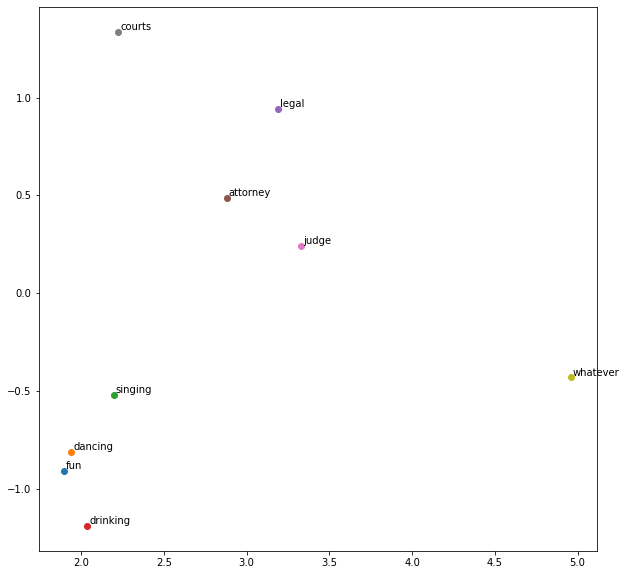

In [80]:
import matplotlib.pyplot as plt
from random import sample

plt.rcParams['figure.figsize'] = [10, 10]

num_words = 5

svd = TruncatedSVD(n_components=2)
word_vectors_2 = svd.fit_transform(word_vectors)

words_to_plot = ["fun","dancing","singing","drinking", "legal","attorney","judge","courts", "whatever"]

for word in words_to_plot:
    i = word_list.index(word)
    plt.scatter(word_vectors_2[i][0],word_vectors_2[i][1])
    plt.annotate(word_list[i],(word_vectors_2[i][0]+0.01,word_vectors_2[i][1]+0.01))
    
plt.draw()

#### Experimenting with LSA

Let's try out some other words using the LSA vectors and find at least one other good (mostly good words) and bad (mostly bad words) example

In [81]:
get_top_10_closest_words("apple",word_vectors_10 ,word_list)
print("----")
get_top_10_closest_words("love",word_vectors_10 ,word_list)

apple 1.0
manhattan 0.9688890540086189
teaspoonful 0.9337397374919909
parthenon 0.9335473757164285
sailor 0.9312875090583851
adjoined 0.9285378841848949
matchless 0.9285378841848949
greased 0.9200659471756834
pleasures 0.9149219368787804
tormented 0.9126715033843337
----
love 1.0
classics 0.9558287045810232
subsided 0.9502495376982584
astonishingly 0.9501279813214899
heaven 0.9470828219688129
deeply 0.9375076757937688
triggered 0.9373018454124609
costume 0.9362111145060076
terrible 0.9340520424666575
aware 0.9335127669065014


> *"manhattan"* for apple is a clearly disambiguiation for interpreting "apple" as New York City. We can increase k value to fix this issue. 

## Pointwise Mutual Information (PMI)

Pointwise mutual information (PMI) is a statistical measure used to identify greater than expectancy frequency of co-occurrence between two words.

Remember from statistics that if two events are independent, then P(x,y) = P(x) * P(y).  PMI is a way of determining just how much more likely two events are than if they were independent of each other.

\begin{equation}
PMI(x,y) =  \log _{2}{\frac {p(x, y)}{p(x)p(y)}}
\end{equation}


$p(x)$ and $p(y)$ refer to the marginal probability of events (in this case, the appearance of words) $x$ and $y$, and $p(x,y)$ is their joint probability (ie, the probability that they appear in the same document, sentence, etc.). If the joint probability is equivalent to the product of the marginal probabilities (the likelihood of appearing regardless of the context), that indicates that x and y are independent, and PMI is near zero (in this case, the numerator and denominator will be approximately equal, and log(1) == 0). 

A greater than zero score indicates positive association, and a greater than zero score negative association.

#### Calculating PMI

PMI can be calculated for individual pairs of words by a targeted collection of statistics, but is often calculated in bulk for large groups of words and applied as a weight prior to dimensionality reduction. In this context, it is typical to calclulate PMI from a large (usually sparse) co-occurrence matrix. Let's begin with a small (non sparse) example involving only a few words 

In [94]:
words = ["fun","dancing","legal","attorney","whatever"]
X = np.array([[0,3,1,0,5],
              [3,0,1,1,5],
              [1,1,0,4,5],
              [0,1,4,0,5],
              [5,5,5,5,0]])
X

array([[0, 3, 1, 0, 5],
       [3, 0, 1, 1, 5],
       [1, 1, 0, 4, 5],
       [0, 1, 4, 0, 5],
       [5, 5, 5, 5, 0]])

#### Symmetric matrices

Here, both the rows and the columns can be labeled using the words in the `words` list (this is a term-term matrix, also sometimes called a collocation matrix or co-occurence matrix). The cells indicate the number of co-occurrences between the two words in the corpus. Note that "co-occurrence" could mean appearing next to each other, within the same span of 5 words, the same sentence, or the same text. 

Generally, the larger the context, the less sparse the matrix will be, but otherwise this choice does not effect the calculation of PMI. 

Let's pull out the number of times that `dancing` appeared with `attorney`.

In [95]:
X[words.index("dancing"), words.index("attorney")]

1

#### Co-occurence

Note that our matrix is symmetric because the co-occurrence relationship is symmetric (that is, if x appears with y in a document, then y also appears with x). 

However, this doesn't always need to be the case when we need to specify the order of occurance in the text.

In [96]:
X[words.index("attorney"), words.index("dancing")]

1

#### PMI denominator

When we have a co-occurrence matrix, we can calculate PMI by summing counts across the matrix. First, the denominator for our probabilities will require having a count of everything in the matrix.

In [97]:
denom = np.sum(X)
denom

60

#### PMI Numerator

The numerators for the marginal probabilities are the sums of the rows and/or columns. If your matrix is symmetric, it doesn't matter whether you sum across the rows or columns

In [98]:
marginal_probs = np.sum(X,axis=0)/denom #We divide by the denominator to transform it into a probability distribution - note that it sums to 1
marginal_probs

array([0.15      , 0.16666667, 0.18333333, 0.16666667, 0.33333333])

#### Joint probabilities

And the joint probabilities are just the entire matrix divided by the total count.

In [99]:
joint_probs = X/denom
joint_probs

array([[0.        , 0.05      , 0.01666667, 0.        , 0.08333333],
       [0.05      , 0.        , 0.01666667, 0.01666667, 0.08333333],
       [0.01666667, 0.01666667, 0.        , 0.06666667, 0.08333333],
       [0.        , 0.01666667, 0.06666667, 0.        , 0.08333333],
       [0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.        ]])

#### Finding the PMI from the joint and marginal probabilities

We can then get $p(x,y)/p(x)p(y)$ by dividing the joint probs first by the marginal probability vector (which *broadcasts* down the columns - that is, it does an element-wise division) and then by a 5 X 1 column vector version of the marginal probability vector (which *broadcasts* across the rows).

In [100]:
PMI = joint_probs/marginal_probs
print(PMI)
marginal_probs_column = marginal_probs.reshape(-1,1)    # then we are going to do this column-wise
print(marginal_probs_column)
PMI /= marginal_probs_column
print(PMI)

[[0.         0.3        0.09090909 0.         0.25      ]
 [0.33333333 0.         0.09090909 0.1        0.25      ]
 [0.11111111 0.1        0.         0.4        0.25      ]
 [0.         0.1        0.36363636 0.         0.25      ]
 [0.55555556 0.5        0.45454545 0.5        0.        ]]
[[0.15      ]
 [0.16666667]
 [0.18333333]
 [0.16666667]
 [0.33333333]]
[[0.         2.         0.60606061 0.         1.66666667]
 [2.         0.         0.54545455 0.6        1.5       ]
 [0.60606061 0.54545455 0.         2.18181818 1.36363636]
 [0.         0.6        2.18181818 0.         1.5       ]
 [1.66666667 1.5        1.36363636 1.5        0.        ]]


#### Logarithm of the PMI

Finally, we take the (base-2) logarithm, adding a little to avoid the problem of log 0 being undefined.

Nice properties of using `log`:
- turns very small numbers into large negative numbers
- more convenient with multiplication (sum in log)

In [101]:
PMI = np.log2(PMI + 0.0001) # since log 0 is undefined
PMI

array([[-13.28771238,   1.00007213,  -0.722228  , -13.28771238,
          0.73705215],
       [  1.00007213, -13.28771238,  -0.87420465,  -0.73672517,
          0.58505868],
       [ -0.722228  ,  -0.87420465, -13.28771238,   1.125597  ,
          0.44756477],
       [-13.28771238,  -0.73672517,   1.125597  , -13.28771238,
          0.58505868],
       [  0.73705215,   0.58505868,   0.44756477,   0.58505868,
        -13.28771238]])

#### Negative PMI

One of the problems with PMI is that the interesting positive associations are drowned out by meaningless negative associations that are simply the result of not having enough data. Positive PMI (or PPMI) is calculated by replacing all negative results with zero

In [102]:
np.maximum(PMI,0)

array([[0.        , 1.00007213, 0.        , 0.        , 0.73705215],
       [1.00007213, 0.        , 0.        , 0.        , 0.58505868],
       [0.        , 0.        , 0.        , 1.125597  , 0.44756477],
       [0.        , 0.        , 1.125597  , 0.        , 0.58505868],
       [0.73705215, 0.58505868, 0.44756477, 0.58505868, 0.        ]])

Note that despite appearing with all the other words a lot, the PMI for `whatever` (row and column 4) is low relative to pairs such as `fun` (row and column 0), `dancing` (row and column 1), since it appears indiscriminately with everything (the only reason the PMIs for `whatever` aren't zero here is because we decided that a word doesn't co-occur with itself).

## Collocation extraction with PMI

#### Collocations

Words may appear to be the basic building blocks of language, but real language is filled with phrases which are clearly remembered and produced as a unit rather than re-generated by each speaker. There are almost certainly more of these than there are actual words in the languages. Two word phrases are the most common, but they can be much longer! Some extremely random examples:

*summer intern, living room area, have anything but, Pay Pal, UC Santa Barbara, remain elusive, the secret service, fast and accurate, regional newspaper, bruise ego, model after, shareholder value, on
equal footing with, long live the, database administrator, just the opposite, storage tank, crack pipe,...*

There are various names for these sort of phrases (which don't always correspond to complete syntactic phrases!), including: formulaic sequences, multiword expressions, idiomatic expressions, lexical bundles, and collocations. We will use this last, fairly theory neutral term here. From a semantic point of view, identifying collocations can be important because they are sometimes *non-compositional* in their meaning, e.g. *kick the bucket*. ("kick the bucket" is a euphemism for "to die").  This can change over time - "New York" was originally named after the city of York, but over time, it became more well-known than its inspiration, and most people think of "New York" as a single term.


Word association measures such as PMI are commonly used to identify collocations in corpora - if a pair of words has a really high PMI, there's a good chance they appear together much more frequently than other words - this is a good sign that they might be a collocation.

#### Collocation hunting

We will avoid using sparse matrices here by only including fairly common words, i.e. words that appear at least 10 times in the Brown corpus. 

Let's create a list of such words and then a pair of dictionaries mapping the words to their index in the array (again, our array will be symmetric!) 

In [103]:
tfs = Counter([word.lower() for word in brown.words()])
word2ind = {}
ind2word = {}
for word,count in tfs.items():
    if count >= 10:
        word2ind[word] = len(word2ind)
        ind2word[len(ind2word)] = word

#### Building a co-occurrence matrix

Now we can build the co-occurrence matrix to have as many rows and columns as we have words

In [104]:
X = np.zeros((len(word2ind),len(word2ind)))
X.shape

(8504, 8504)

#### Filling the matrix

We will get the counts we need by iterating over the corpus. We need to do sentences this time because we need to know when words appear together.  Unlike our previous experiment, the matrix will not be symmetric, because P(x ... y) is not the same as P(y ... x): order is now important!

> Notice here "New York" means we add 1 to the cell of `row = 'New'`,`column = 'York'`, but not to `row = 'York'`,`column = 'New'`.

In [105]:
for sent in brown.sents():
    for i in range(len(sent) -1):
        word1,word2 = sent[i].lower(),sent[i+1].lower() # looking at the current word and the next word
        if word1 in word2ind and word2 in word2ind:
            X[word2ind[word1], word2ind[word2]] += 1

#### PMI of a non-symmetric matrix

Exercise: let's calculate PMI as we did in the last section. The only distinct part is that we need to calculate $p(x)$ (probability of the first word) and $p(y)$ (probability of the second word) separately because the matrix is not symmetric this time.

In [106]:
X_smoothed = X + 0.0001 # smoothing to avoid divide by zero errors

denom = np.sum(X_smoothed)
# this time we do by row and column separately
marginal_probs_x = (np.sum(X_smoothed,axis=0,keepdims=True))/denom
marginal_probs_y = (np.sum(X_smoothed,axis=1,keepdims=True))/denom
joint_probs = X_smoothed/denom
PMI = joint_probs/marginal_probs_x
PMI /= marginal_probs_y
PMI = np.log2(PMI)
PMI = np.maximum(PMI, 0)

PMI

array([[ 0.        ,  2.60707942,  1.79265995, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 11.60063934, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#### Finding the largest PMI

- What we are doing here: we find the pairs with the largest PMI, which indicates the most close relations between these two words.

Now we can pull out those word pairs with the highest PMI and take a look at the top 50. We will use argsort, but since its a 2d array we need some extra help to get the right kind of index

> `np.unravel_index` transforms the *list* back to a matrix in tuples like (0,1), (0,2) where we can assign the first/second indices.

In [107]:
first_indices, second_indices = np.unravel_index(np.argsort(PMI, axis=None), PMI.shape)
for i in range(len(first_indices) -1, len(first_indices) -51, -1):  # we just want to look at the top 50
    print(ind2word[first_indices[i]],ind2word[second_indices[i]])
    print(PMI[first_indices[i],second_indices[i]])

hong kong
16.155529252486364
viet nam
15.946551564077522
santa barbara
15.862446350606183
el paso
15.692461006158197
simms purdew
15.573160884657739
pathet lao
15.554193922205588
herald tribune
15.40565569351671
anionic binding
15.353325414692792
puerto rico
15.322960944220144
wtv antigen
15.269705029044857
lo shu
15.258401214479695
carbon tetrachloride
15.249074491123215
vincent berger
15.177894016232042
potato chip
15.11359662437035
santa maria
15.080929959125575
la marina
15.018609785738057
oxidation pond
15.00596431865716
willie mays
15.000364266255836
miscellaneous soils
14.984916775652387
unwed mothers
14.949693723077202
drainage ditch
14.920237110176902
kohnstamm reactivity
14.801451286468303
pituitary tsh
14.758315284108143
egg compartment
14.702216299731889
phonologic subsystems
14.674964178294497
wildlife habitat
14.656346471204886
cardinal newman
14.650200909667962
urethane foams
14.638604465097778
presiding elder
14.59831622860242
peaceful coexistence
14.570851704474006
syn

#### $\chi^2$

It works! Note that PMI is only one of many possible *association measures*. Another popular one is $\chi^2$, which can also be calculated using the stats in the original co-occurrence matrix, though not quite as cleanly (we won't try do do this in a vectorized way). To use $\chi^2$, for each pair we create a confusion matrix of counts


|xy |~xy|
|---|---|
|x~y|\~x\~y|

where ~x indicates an absence of x

In [108]:
from scipy.stats import chi2_contingency

total_count = np.sum(X)
counts_x =np.sum(X,axis=0)
counts_y =np.sum(X,axis=1)
to_sort = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        count_xy = X[i,j]
        if count_xy >= 5:
            count_x = counts_x[j]
            count_y = counts_y[i]
            # we construct the confusion matrix
            confusion = [[count_xy,count_y - count_xy],[count_x - count_xy,total_count - count_x - count_y + count_xy]]
            # we use the chi2_contigency to calculate chi score
            p = chi2_contingency(confusion)[1]
            to_sort.append((p,1/count_xy,(ind2word[i],ind2word[j])))

to_sort.sort()
to_sort[:50]

[(0.0, 0.00010291242152927858, ('of', 'the')),
 (0.0, 0.00015873015873015873, (',', 'and')),
 (0.0, 0.00016597510373443983, ('in', 'the')),
 (0.0, 0.0002870264064293915, ('to', 'the')),
 (0.0, 0.0003002101471029721, ("''", '.')),
 (0.0, 0.00035932446999640676, (';', ';')),
 (0.0, 0.00040551500405515005, ('on', 'the')),
 (0.0, 0.00042625745950554135, ('?', '?')),
 (0.0, 0.0004921259842519685, ("''", ',')),
 (0.0, 0.0005387931034482759, (',', 'but')),
 (0.0, 0.0005399568034557236, ('for', 'the')),
 (0.0, 0.0005820721769499418, ('to', 'be')),
 (0.0, 0.0006042296072507553, ('at', 'the')),
 (0.0, 0.0006523157208088715, ('with', 'the')),
 (0.0, 0.0006693440428380187, (',', 'he')),
 (0.0, 0.0006802721088435374, ('it', 'is')),
 (0.0, 0.0007072135785007072, ('in', 'a')),
 (0.0, 0.0007087172218284905, ('from', 'the')),
 (0.0, 0.0007423904974016332, ('by', 'the')),
 (0.0, 0.0007716049382716049, ('it', 'was')),
 (0.0, 0.0009149130832570906, (',', '``')),
 (0.0, 0.0009191176470588235, ('he', 'was')

#### Biases

$\chi^2$ generally prefers pairs where there are many instances and therefore strong statistical support. Association measures generally have natural biases towards very common or very rare collocations. 

## Word2Vec

#### What is Word2Vec?

Like LSA, Word2Vec creates dense vector representations of words (known generally as *embeddings*, especially in the context of neural network models) based on word co-occurrence. We can use the `gensim` package to build new representations, but we will start by using some pre-trained word embeddings available in NLTK. 

- They are trained on much larger dataset;
- word2vec is a better way to represent the term-term matrix

Note that these embeddings are way better than our LSA embeddings not only because Word2Vec is a better way to create those embeddings (though it typically is), but because it is trained on billions of words of text (neural models are typically very data-hungry: they perform much better when they have billions of words to train from).

In [109]:
import gensim
import nltk
from nltk.data import find
nltk.download("word2vec_sample")
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/lxy/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


#### Evaluating Word2Vec

Let's test out some of the words we have been looking at...  Note that W2V doesn't have the same issue where the top word is itself, but it looks like this model was not lower-cased before training.

In [110]:
word2vec_model.similar_by_word("fun")

[('enjoyable', 0.686113715171814),
 ('Fun', 0.5848220586776733),
 ('funny', 0.5779312252998352),
 ('entertaining', 0.5777135491371155),
 ('nice', 0.55433189868927),
 ('awesome', 0.5507883429527283),
 ('laugh', 0.5425649285316467),
 ('wonderful', 0.522951066493988),
 ('fabulous', 0.5222398638725281),
 ('enjoy', 0.5214759111404419)]

In [111]:
word2vec_model.similar_by_word("legislation")

[('bill', 0.8184376955032349),
 ('Legislation', 0.7706775069236755),
 ('amendment', 0.6887384057044983),
 ('amendments', 0.6493344902992249),
 ('repeal', 0.6031153798103333),
 ('laws', 0.5993766188621521),
 ('Senate', 0.5940187573432922),
 ('law', 0.5800462961196899),
 ('reform', 0.5782173275947571),
 ('proposal', 0.5761774778366089)]

#### The power of word embeddings

Now let's work with an example that shows how truly semantic word2vec embeddings are. Let's start with the name of a country, say Thailand.

In [112]:
word2vec_model.similar_by_word("Thailand")

[('Thai', 0.7535779476165771),
 ('Cambodia', 0.7131430506706238),
 ('Bangkok', 0.7014992237091064),
 ('Indonesia', 0.6669521927833557),
 ('Laos', 0.6205480694770813),
 ('Nepal', 0.6016077399253845),
 ('Philippines', 0.5724481344223022),
 ('Vietnam', 0.5518046617507935),
 ('Japan', 0.5379639267921448),
 ('Indonesian', 0.512627899646759)]

#### What is the capital of Thailand?

Looks pretty reasonable! Now what if we wanted to know what Thailand's capital is (it's Bangkok). Can we find that out using word vectors alone? Well, yes! And in multiple ways!

In [113]:
word2vec_model["Thailand"] 

array([ 0.0367943 , -0.0392473 ,  0.00335237,  0.0798028 , -0.064758  ,
        0.020196  ,  0.0198689 , -0.134749  , -0.0467697 ,  0.048405  ,
        0.0533109 , -0.0598521 ,  0.0889606 , -0.0955018 ,  0.0230578 ,
       -0.0729346 , -0.0869982 ,  0.048405  ,  0.0269825 , -0.0264919 ,
        0.0683557 , -0.0441532 ,  0.00625504,  0.00789034,  0.0381026 ,
       -0.053638  , -0.0709722 , -0.00419047,  0.0167619 ,  0.125591  ,
       -0.080457  , -0.069664  , -0.0245296 , -0.0202778 ,  0.0227307 ,
       -0.0169254 , -0.137366  ,  0.0276366 ,  0.069664  , -0.0230578 ,
       -0.0345049 ,  0.0588709 ,  0.0235484 ,  0.0513486 , -0.00805387,
       -0.0470968 , -0.0595251 ,  0.104659  ,  0.0994265 ,  0.00221788,
       -0.059198  ,  0.00080743, -0.0366308 ,  0.0503674 , -0.0660663 ,
        0.043172  , -0.0677016 , -0.0330331 ,  0.0289449 , -0.00133891,
       -0.0480779 ,  0.024366  ,  0.00531474,  0.0474238 ,  0.0219131 ,
       -0.053965  ,  0.0546192 , -0.0758781 ,  0.0611604 ,  0.05

#### The meaning of vectors

Ok - that doesn't really tell us much.  The vector for "Thailand" is just a string of numbers.  Unless we compare every single city vector to that one, we won't find "Bangkok" (and even if we do, there's no guarantee that that's the most similar).  Instead, we can take advantage of some neat properties of vectors.

In [114]:
word2vec_model.similar_by_vector(word2vec_model["Thailand"] + word2vec_model["Athens"] - word2vec_model["Greece"])

[('Bangkok', 0.6855698823928833),
 ('Thailand', 0.6715706586837769),
 ('Thai', 0.5496402978897095),
 ('Vientiane', 0.5187898278236389),
 ('Cambodia', 0.4744531214237213),
 ('Athens', 0.46452659368515015),
 ('Jakarta', 0.43699127435684204),
 ('Laos', 0.4234437346458435),
 ('Vietnam', 0.4101414382457733),
 ('Taipei', 0.3996793329715729)]

#### Analogies

How did that work?  The secret is what is being encoded in our vectors: Hopefully, "Athens" has some information about "Greece" stored in the vector.  If we subtract "Greece" from "Athens", we are effectively stripping out the country, and what remains is a generic "Capital City".  Then, when we add "Thailand" back in, the closest vector that has information about "Thailand" and "capital city" is "Bangkok".  This task is known as the analogy task, and can be used (with varying results) whenever two words have a similar relationship.

#### Analogy exercises:

Exercise: Let's think of other cases where there is an analogous relationship between two pairs of words (i.e. both pairs involve the same relationship), and see if you can make it work with these vectors (hint: lots of word morphology falls into this category).

In [115]:
# your code here
word2vec_model.similar_by_vector(word2vec_model["man"] + word2vec_model["women"] - word2vec_model["woman"])
# your code here

[('men', 0.8470770120620728),
 ('women', 0.7644327878952026),
 ('Men', 0.6137845516204834),
 ('man', 0.5263832807540894),
 ('boys', 0.5157146453857422),
 ('girls', 0.4952755570411682),
 ('Women', 0.48253336548805237),
 ('Americans', 0.4793965816497803),
 ('males', 0.47085869312286377),
 ('youth', 0.4691276252269745)]

In [116]:
# your code here
word2vec_model.similar_by_vector(word2vec_model["apple"] + word2vec_model["fruit"] - word2vec_model["pie"])
# your code here

[('fruit', 0.7888390421867371),
 ('apple', 0.7327007055282593),
 ('grapes', 0.6048467755317688),
 ('berry', 0.6024685502052307),
 ('grape', 0.6014249324798584),
 ('apples', 0.592602014541626),
 ('pears', 0.5905410647392273),
 ('fruits', 0.5819533467292786),
 ('berries', 0.5757580399513245),
 ('orchards', 0.564185619354248)]

#### Evaluating Word Analogies

There's a huge list of analogies of this sort provided with this notebook. You can use it to evaluate how much your vectors capture proper semantics. The other main kind of *intrinistic* evaluation of word vectors is based on trying to capture word similarity.

In general, an *intrinsic* evaluation will evaluate the results against a hand-annotated test set, while an *extrinsic* evaluation will evaluate them with a downstream task (such as machine translation).

In [117]:
word2vec_model.evaluate_word_analogies('analogies.txt')

(0.6536421499292786,
 [{'section': 'capital-common-countries',
   'correct': [('ATHENS', 'GREECE', 'BANGKOK', 'THAILAND'),
    ('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
    ('ATHENS', 'GREECE', 'BERN', 'SWITZERLAND'),
    ('ATHENS', 'GREECE', 'CAIRO', 'EGYPT'),
    ('ATHENS', 'GREECE', 'HAVANA', 'CUBA'),
    ('ATHENS', 'GREECE', 'MADRID', 'SPAIN'),
    ('ATHENS', 'GREECE', 'MOSCOW', 'RUSSIA'),
    ('ATHENS', 'GREECE', 'OSLO', 'NORWAY'),
    ('ATHENS', 'GREECE', 'OTTAWA', 'CANADA'),
    ('ATHENS', 'GREECE', 'PARIS', 'FRANCE'),
    ('ATHENS', 'GREECE', 'ROME', 'ITALY'),
    ('ATHENS', 'GREECE', 'TOKYO', 'JAPAN'),
    ('BANGKOK', 'THAILAND', 'BERLIN', 'GERMANY'),
    ('BANGKOK', 'THAILAND', 'BERN', 'SWITZERLAND'),
    ('BANGKOK', 'THAILAND', 'CAIRO', 'EGYPT'),
    ('BANGKOK', 'THAILAND', 'HAVANA', 'CUBA'),
    ('BANGKOK', 'THAILAND', 'MADRID', 'SPAIN'),
    ('BANGKOK', 'THAILAND', 'MOSCOW', 'RUSSIA'),
    ('BANGKOK', 'THAILAND', 'OSLO', 'NORWAY'),
    ('BANGKOK', 'THAILAND', 'OTTAWA', 'C

The embeddings included in NLTK are just a relatively small sample of the most common words. If you want more, try this [full set of Google vectors]( https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) (it's very big!)

#### How to build word vectors

[Here's a good passage about word2vec](https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1).


Now, let's look closer at how these vectors are built. Although they are based on word co-occurrence, they don't involve explicity building a co-occurrence matrix like LSA does. The core of Word2Vec is actually a simple "supervised" learning task that can be set up using raw text: predicting a word based on a word (or words) in its immediate vicinity.

Note that there are two flavours of this, one where the prediction involves pairs of words near each other (called skip-gram), and one where we predict one word given a contextual bag of words around it (CBOW). 

CBOW: {The, is, barking} -> "dog" <br>
Skip-gram: "dog" -> {The, is, barking}
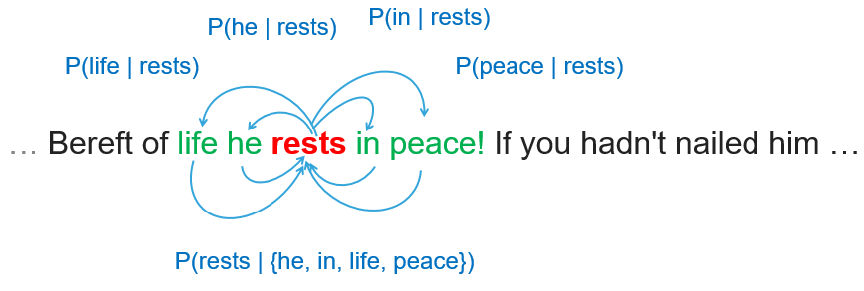

#### The probabilities of Word vectors

Where do these probabilities come from? Well, NOT simple conditional probability, that wouldn't get us anywhere. Rather, they are the output of a logistic regression classifier. Logistic regression calculates the probability that a particular instance belongs to one of two classes based on the following formula (which uses the *sigmoid* function to ensure a proper probability):

$$p = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_mx_m )}}$$

In the case where there are multiple classes, it is typically calculated as follows (using the *softmax* function to ensure a proper probability):

$$ p(c) = \frac{e^{\boldsymbol\beta_c \cdot \mathbf{X}}}{\sum_{k=1}^{K} e^{\boldsymbol\beta_k \cdot \mathbf{X}}}$$


The key part of logistic regression are the exponents which (excluding the constant bias) consists of the dot product between a feature vector $X$ and a class-specific weight vector $\beta_c$: when this dot product is high, the probability output is high.

(Remember that cosine similarity is just a normalized dot product, so this is closely related to the kind of similarity calculations we've been doing!)

#### How do we predict words from this?

But what does this have to do with conditional probabilities for predicting words? 

Well, if we had dense vector representations of our words, we could calculate a probabilty for one given another by treating the vector corresponding to one of these words as the feature vector, and the other as the weight vector. And we would hope that words in near vicinity would be semantically related and hence have high dot products and therefore high probabilities, meaning that we could accurately predict one word using another word in its context. Irrelevant words that are unlikely to appear in the context would in turn have low dot products and low probabilities using this classifier. This provides us with a learning objective, which we can then use to learn the dense representations for words that we desire. 

#### Joint learning of weights and features

Note: in normal training of a logistic regression model the training process would involve only finding good weights for the model, but here we are finding both good weights and a good feature representation simultaneously. We can't use an off-the-shelf logistic regression model for this, a special version is needed (enter PyTorch).

#### Skip-gram

But a couple more things we need to know before we look at the code for word2vec skip-gram:

- We will actually use two different sets of embeddings, one to represent the target word, and one to represent the context word; this works better than trying to have a single representation. These two sets of embeddings are sometimes viewed as matrices T and C (target and context), and you will also see them refered to as U and V, similar to the matrices produced by a matrix decomposition (Advanced: this is because you are implicitly doing a matrix decomposition, see this [paper](https://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf)!)


- We framed this in terms of predicting a word given a context. In such a set up, we would use the multiclass formulation of logistic regression given above, which each word corresponding to a class. However, this requires normalizing over the entire vocabulary every time (the denominator in the softmax formula) to get a probability.
- Instead, we can be more efficient by formulating the problem as the two-class problem, using the sigmoid formulation for logistic regression: given two words, are they neighbours?
- In this formulation, to build a proper classifier we need to randomly sample negative examples so that we have both positive and negative instances of our problem
- The major parameters of the skip-gram with negative sampling (SGNS) model are therefore
   - The window for deciding if two words are considered neighbours
   - The dimensionality of the embeddings
   - The number of negative samples
   - The number of passes over the corpus we will do (i.e. iterations or epochs)
   - It's also typical to complete ignore words less than a certain count
   
- A proper implementation of this would use batch processing (and have a parameter related to that) but to keep the code simple we are going to update the model a word pair at a time. See, for instance, this [implementation](https://rguigoures.github.io/word2vec_pytorch/) from which the below was adapted.
    
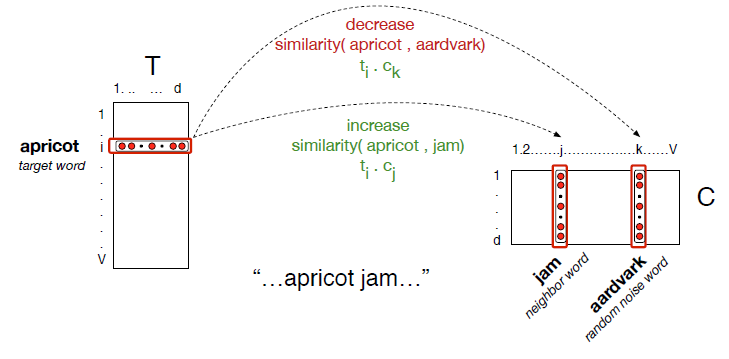

#### W2VSGNS (Word2Vec with Skip-gram and negative sampling)

Let's first set up the W2VSGNS module, which contains the embeddings and knows how they are multiplied together to get a (log) probability for a particular target/context pair

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class W2VSGNS(nn.Module):
    ''' A module which implements SGNS word2vec. A pair of words is passed to the forward method,
    and after taking the dot product of the target/context embeddings for these words, we return
    a sigmoid output indicating the probability that the two words appear near each other'''

    def __init__(self, embedding_size, vocab_size):
        super(W2VSGNS, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)

    def forward(self, target_word, context_word):
        emb_target = self.embeddings_target(torch.LongTensor([target_word])).squeeze()
        emb_context = self.embeddings_context(torch.LongTensor([context_word])).squeeze()
        emb_dot = torch.dot(emb_target, emb_context)
        prob = F.logsigmoid(emb_dot)
        return prob

#### Training

To build our model we are going to iterate over the Brown corpus and, for each word, we extract pairs in the immediate vincinity of the word and do the positive version (where higher dot product means lower loss), and then randomly select from all other words and do the negative version (where lower dot product means lower loss). 

In [ ]:
import torch.optim as optim
from random import sample

tfs = Counter([word.lower() for word in brown.words()])
word2ind = {}
#ind2word = {}
for word,count in tfs.items():
    if count >= 5:
        word2ind[word] = len(word2ind)
        #ind2word[len(ind2word)] = word

vocabulary = set(word2ind)
vocabulary_size = len(vocabulary)
embedding_size = 100
total_epochs = 10
window_size = 5
negative_examples = 10

model = W2VSGNS(embedding_size, vocabulary_size)
optimizer = optim.Adam(model.parameters())

itr = 0

while itr < total_epochs:
    total_loss = 0
    sent_count = 0
    for sent in brown.sents():
        sent = [word.lower() for word in sent]
        print(sent_count)
        sent_count += 1
        for i in range(len(sent)):
            t_word = sent[i] 
            if t_word in word2ind:
                context_words = set(sent[max(0,i-window_size):min(i+window_size,len(sent))])
                for c_word in context_words: # positive examples
                    if c_word in word2ind:
                        model.zero_grad()
                        loss = -model(word2ind[t_word], word2ind[c_word])
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.data
                other_words = vocabulary - context_words
                for n_word in sample(other_words,negative_examples):  # negative examples
                    if n_word in word2ind:
                        model.zero_grad()
                        loss = model(word2ind[t_word], word2ind[n_word])
                        loss.backward()
                        optimizer.step()
                        total_loss += loss.data
        
    print("Epoch: ",itr)
    print("Total Loss: ",total_loss)
    itr += 1

0


<ipython-input-58-6912df65dfd7>:43: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for n_word in sample(other_words,negative_examples):  # negative examples


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


KeyboardInterrupt: 

#### Our code is too slow! (Always batch!)

So, yeah, this is way too slow, mostly because we didn't do batching (Always do batching!). Fortunately, the word2vec training included in gensim is fast enough to be fine for training a model on a corpus as small as the Brown. And if you need serious speed because you have a huge corpus, you can use the [C implementation](https://code.google.com/archive/p/word2vec/).

Advanced: if you want to understand better how all the major techniques for deriving embeddings (including [GloVe](https://nlp.stanford.edu/projects/glove/), an advanced approach also based on a special decomposition of the co-occurrence matrix) compare, try reading [this excellent paper](https://www.aclweb.org/anthology/Q15-1016.pdf). It will give you a better understanding of some model parameters that we haven't talked about here.